<a href="https://colab.research.google.com/github/rezniknn/yp_churn_prediction/blob/main/Churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Выпускной проект - Телеком

## Цели проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача данного проекта — обучить на этих данных модель для прогноза оттока клиентов.

## Загрузка данных

In [164]:
from sqlalchemy import create_engine

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    auc,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import shap

In [2]:
RANDOM_STATE = 120624

In [3]:
db_config = {
    'user': 'praktikum_student',# имя пользователя
    'pwd': 'Sdf4$2;d-d30pp',# пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-science-final'# название базы данных
}

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

In [5]:
con = create_engine(connection_string)

In [6]:
pd.read_sql_query('''
    SELECT schema_name
    FROM information_schema.schemata
''', con)

,schema_name
0,information_schema
1,public
2,pg_catalog
3,telecom
4,steel


In [7]:
df_contract =  pd.read_sql_query('''
    SELECT *
    FROM telecom.contract
''', con)
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [8]:
df_personal =  pd.read_sql_query('''
    SELECT *
    FROM telecom.personal
''', con)
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
df_internet =  pd.read_sql_query('''
    SELECT *
    FROM telecom.internet
''', con)
df_internet.head()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


In [10]:
df_phone =  pd.read_sql_query('''
    SELECT *
    FROM telecom.phone
''', con)
df_phone.head()

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


### Выводы

Все таблицы, приведенные в условии задачи, присутствуют в базе данных и содержат данные:
- `contract` — информация о договорах
- `personal` — персональные данные клиентов
- `internet` — информация об интернет-услугах
- `phone` — информация об услугах телефонии

Во всех таблицах есть ключ `customerID`, который можно использовать для объединения таблиц

## Исследовательский анализ

### Договоры

In [11]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


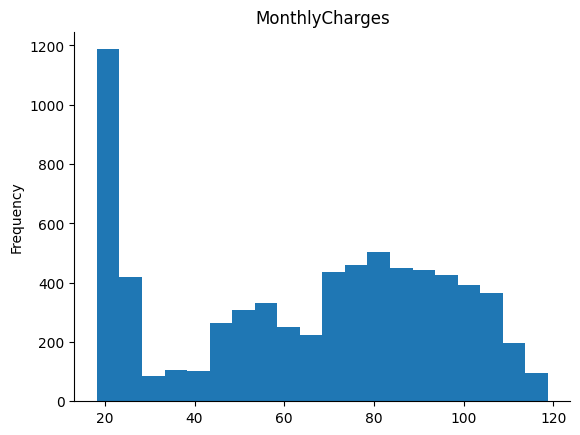

In [12]:
# @title MonthlyCharges
df_contract['MonthlyCharges'].plot(kind='hist', bins=20, title='MonthlyCharges')
plt.gca().spines[['top', 'right',]].set_visible(False)

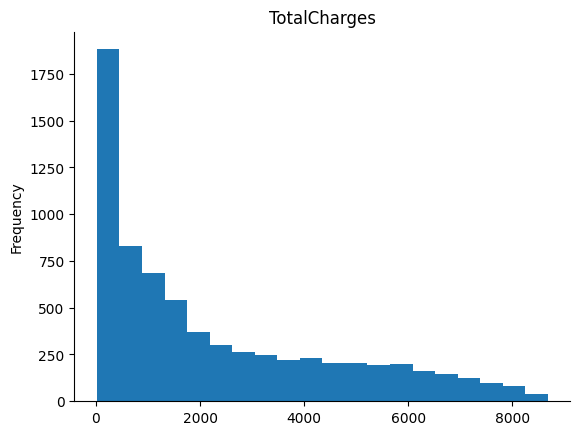

In [13]:
# @title TotalCharges
df_contract['TotalCharges'].plot(kind='hist', bins=20, title='TotalCharges')
plt.gca().spines[['top', 'right',]].set_visible(False)

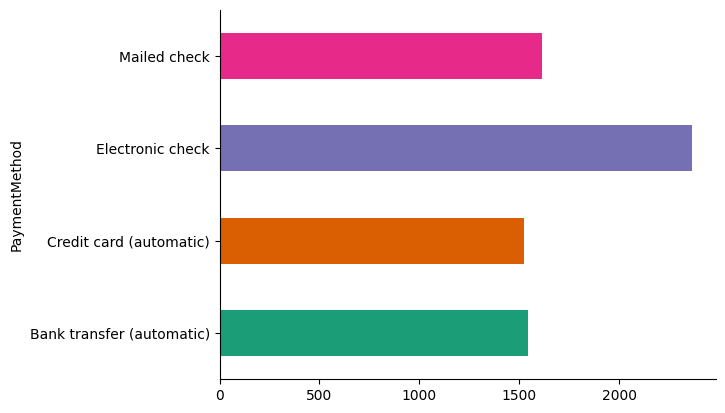

In [14]:
# @title PaymentMethod
df_contract.groupby('PaymentMethod').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

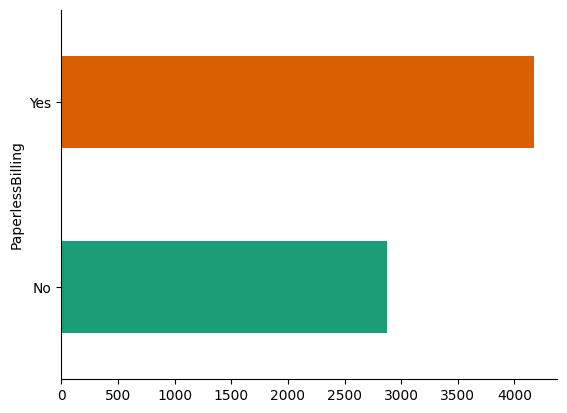

In [15]:
# @title PaperlessBilling
df_contract.groupby('PaperlessBilling').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

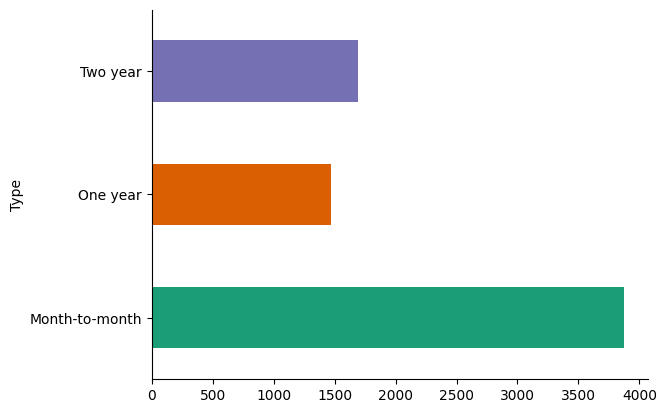

In [16]:
# @title Type
df_contract.groupby('Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
df_contract.isna().sum()

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64

In [18]:
df_contract.duplicated().sum()

0

In [19]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d')

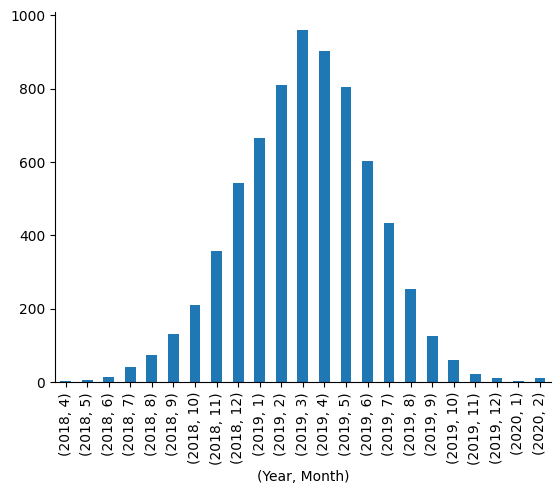

In [20]:
# @title BeginDate
df_contract.groupby([df_contract["BeginDate"].dt.year, df_contract["BeginDate"].dt.month])['customerID'].count().plot(kind="bar", xlabel='(Year, Month)')
plt.gca().spines[['top', 'right',]].set_visible(False)

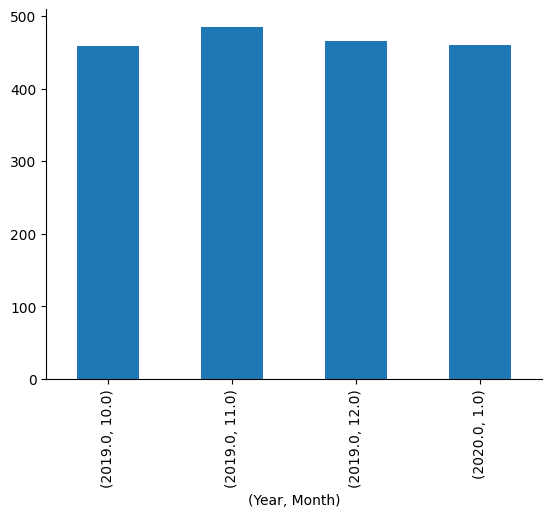

In [21]:
# @title EndDate
df_contract.groupby([df_contract["EndDate"].dt.year, df_contract["EndDate"].dt.month])['customerID'].count().plot(kind="bar", xlabel='(Year, Month)')
plt.gca().spines[['top', 'right',]].set_visible(False)

В таблице Договоры пропуски присутствуют в столбцах `EndDate` и `TotalCharges`. Пропуски в первом столбце - нормальное явление и говорят о том, что клиенты продолжают пользоваться сервисом, пропуски во втором столбце стоит обработать.

Аномалий в признаках таблице с договорами не замечено. Как категориальные, так и численные признаки не содержат выбросов. Таблица не содержит дубликатов.

Распределение количества клиентов по дате начала договора похоже на нормальное распределение со средним в районе марта-апреля 2019 года, общий диапозон - от апреля 2018 года до февраля 2020 года.

Даты расторжения договоров распределены приблизительно равномерно по четырем месяцам в период с октября 2019 года по январь 2020 года.

### Персональные данные клиентов

In [22]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


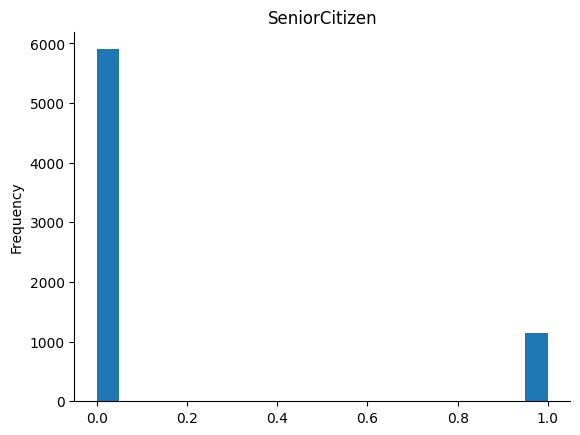

In [23]:
# @title SeniorCitizen
df_personal['SeniorCitizen'].plot(kind='hist', bins=20, title='SeniorCitizen')
plt.gca().spines[['top', 'right',]].set_visible(False)

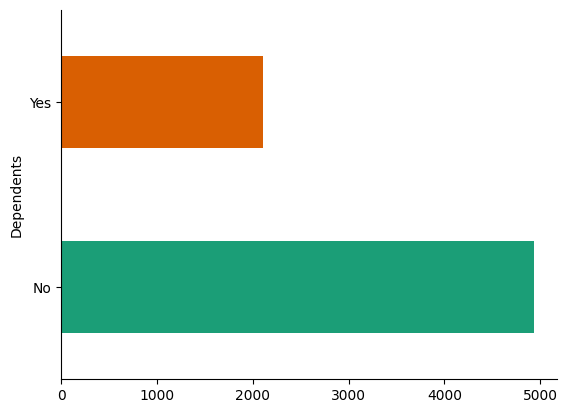

In [24]:
# @title Dependents
df_personal.groupby('Dependents').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

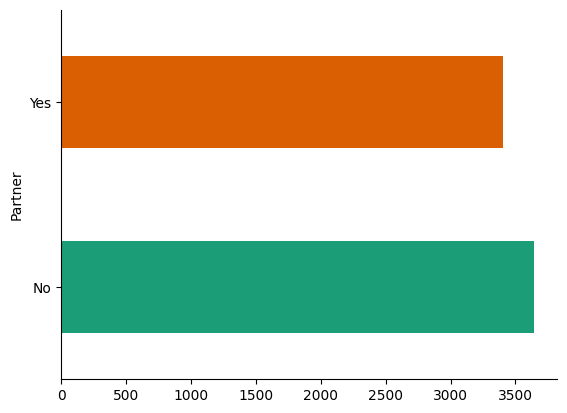

In [25]:
# @title Partner
df_personal.groupby('Partner').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

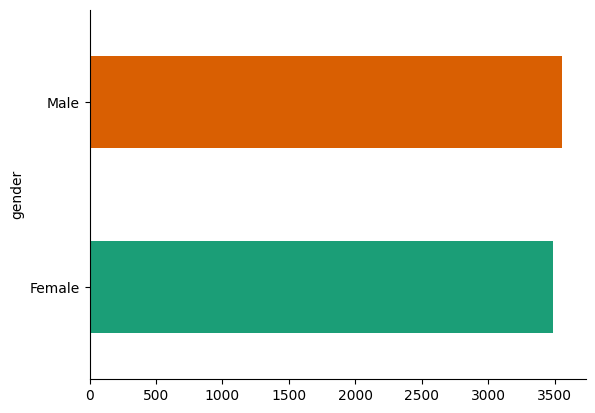

In [26]:
# @title gender
df_personal.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [27]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [28]:
df_personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [29]:
df_personal.duplicated().sum()

0

Таблица с персональными данными клиентов не содержит аномалий, дубликатов или пропусков.

### Информация об интернет-услугах

In [30]:
df_internet.head()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


In [31]:
header = df_internet.iloc[0]
df_internet = df_internet[1:]
df_internet.columns = header

df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


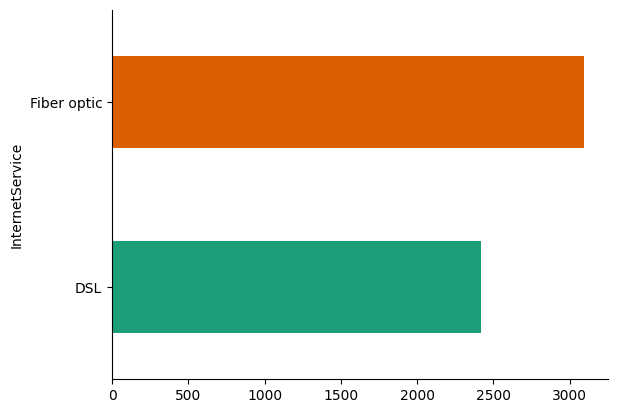

In [32]:
# @title InternetService
df_internet.groupby('InternetService').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

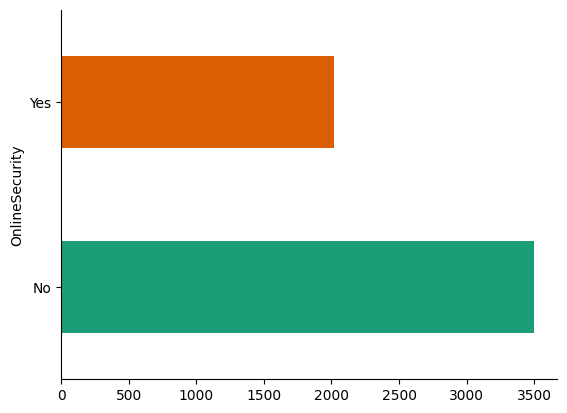

In [33]:
# @title OnlineSecurity
df_internet.groupby('OnlineSecurity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

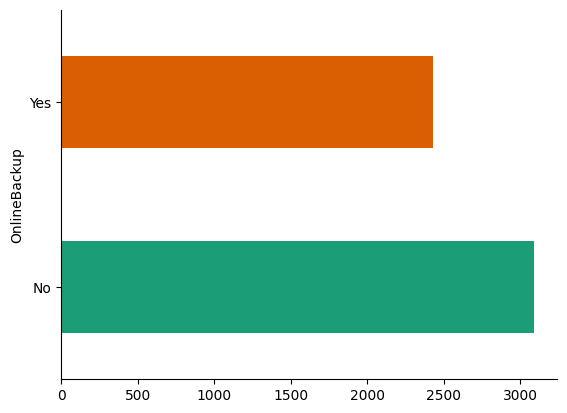

In [34]:
# @title OnlineBackup
df_internet.groupby('OnlineBackup').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

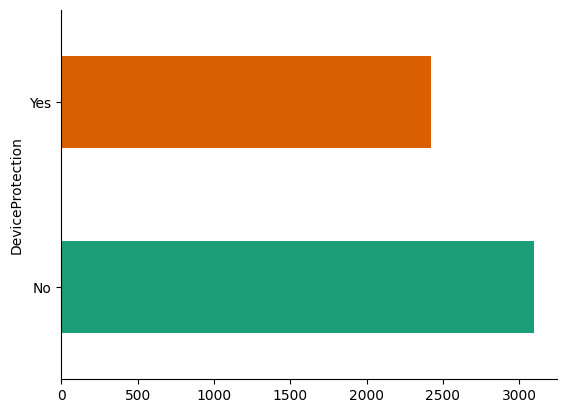

In [35]:
# @title DeviceProtection
df_internet.groupby('DeviceProtection').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

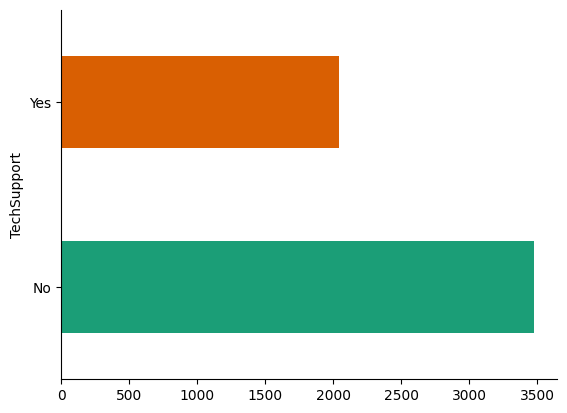

In [36]:
# @title TechSupport
df_internet.groupby('TechSupport').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

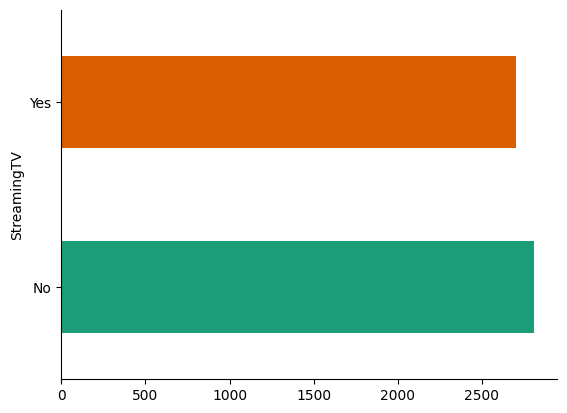

In [37]:
# @title StreamingTV
df_internet.groupby('StreamingTV').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

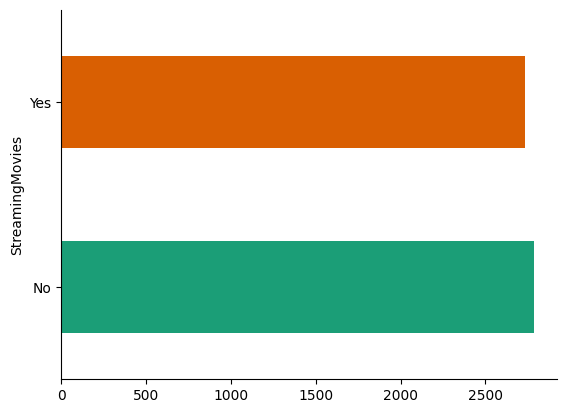

In [38]:
# @title StreamingMovies
df_internet.groupby('StreamingMovies').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [39]:
df_internet.isna().sum()

0
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [40]:
df_internet.duplicated().sum()

0

Таблица с информацией об интернет-сервисах клиентов не содержит аномалий, дубликатов или пропусков.

### Информация об услугах телефонии

In [41]:
df_phone.head

<bound method NDFrame.head of               c1             c2
0     customerID  MultipleLines
1     5575-GNVDE             No
2     3668-QPYBK             No
3     9237-HQITU             No
4     9305-CDSKC            Yes
...          ...            ...
6357  2569-WGERO             No
6358  6840-RESVB            Yes
6359  2234-XADUH            Yes
6360  8361-LTMKD            Yes
6361  3186-AJIEK             No

[6362 rows x 2 columns]>

In [42]:
header = df_phone.iloc[0]
df_phone = df_phone[1:]
df_phone.columns = header

df_phone.head()

,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


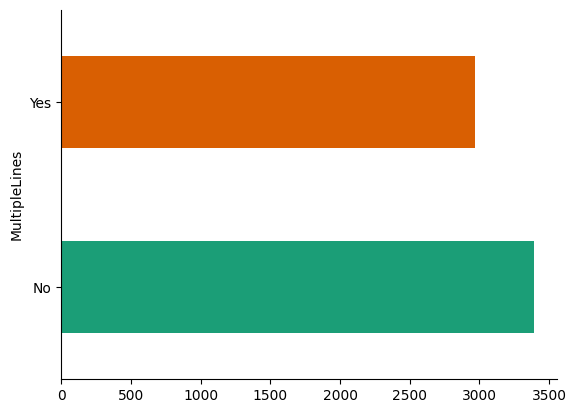

In [43]:
# @title MultipleLines
df_phone.groupby('MultipleLines').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [44]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [45]:
df_phone.isna().sum()

0
customerID       0
MultipleLines    0
dtype: int64

In [46]:
df_phone.duplicated().sum()

0

Таблица с информацией об услугах телефонии клиентов не содержит аномалий, дубликатов или пропусков.

### Выводы



*   В таблице Договоры пропуски присутствуют в столбцах EndDate и TotalCharges. Пропуски в первом столбце - нормальное явление и говорят о том, что клиенты продолжают пользоваться сервисом, пропуски во втором столбце стоит обработать. Аномалий в признаках этой таблицы не замечено. Как категориальные, так и численные признаки не содержат выбросов. Таблица не содержит дубликатов.

*   Таблица с персональными данными клиентов, информацией об интернет-услугах и об услугах телефонии не содержит аномалий, дубликатов или пропусков.



## Предобработка данных

### Объединение таблиц

In [47]:
df_contract.shape

(7043, 8)

In [48]:
len(df_contract['customerID'].unique())

7043

In [49]:
df_personal.shape

(7043, 5)

In [50]:
len(df_personal['customerID'].unique())

7043

In [51]:
df_internet.shape

(5517, 8)

In [52]:
len(df_internet['customerID'].unique())

5517

In [53]:
df_phone.shape

(6361, 2)

In [54]:
len(df_phone['customerID'].unique())

6361

In [55]:
df_merged = pd.merge(
    df_contract,
    df_personal,
    on='customerID'
)

In [56]:
df_merged.shape

(7043, 12)

In [57]:
df_merged = pd.merge(
    df_merged,
    df_internet,
    on='customerID',
    how='left'
)

In [58]:
df_merged.shape

(7043, 19)

In [59]:
df_merged = pd.merge(
    df_merged,
    df_phone,
    on='customerID',
    how='left'
)

In [60]:
df_merged.shape

(7043, 20)

In [61]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

In [62]:
columns_with_na = [
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines'
]
df_merged[columns_with_na] = df_merged[columns_with_na].fillna('No')

In [63]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

### Подготовка данных

In [64]:
df_merged['Churned'] = df_merged['EndDate'].notna()

In [65]:
df_merged['Churned'].value_counts()

Churned
False    5174
True     1869
Name: count, dtype: int64

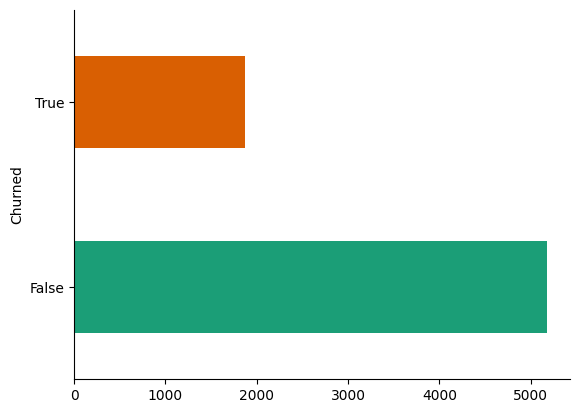

In [66]:
# @title Churned
df_merged.groupby('Churned').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [67]:
df_merged['BeginMonth'] = df_merged['BeginDate'].dt.month
df_merged['BeginYear'] = df_merged['BeginDate'].dt.year

In [68]:
df_merged.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Churned',
       'BeginMonth', 'BeginYear'],
      dtype='object')

In [69]:
df_merged = df_merged.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [70]:
df_merged = df_merged.rename(columns={'Type': 'ContractType', 'gender': 'Gender'})

In [71]:
df_merged.columns

Index(['ContractType', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'Churned', 'BeginMonth', 'BeginYear'],
      dtype='object')

In [72]:
numeric_columns = [
    'MonthlyCharges',
    'TotalCharges',
    #'ContractDuration'
]
categorical_columns = [
    'ContractType',
    'PaymentMethod',
    'Gender',
    'InternetService',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines',
    'BeginMonth',
    'BeginYear',
]
target = 'Churned'

### Корреляции

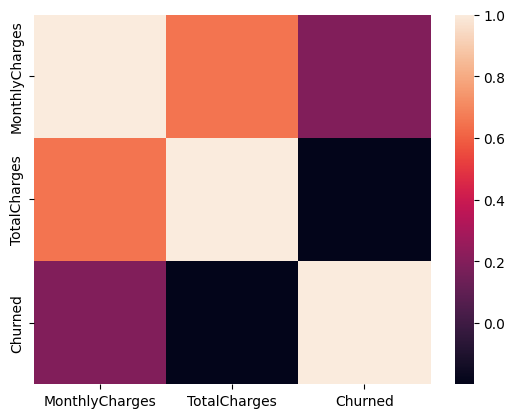

In [73]:
sns.heatmap(df_merged[numeric_columns + [target]].corr());

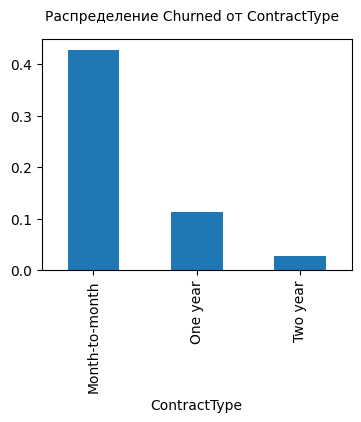

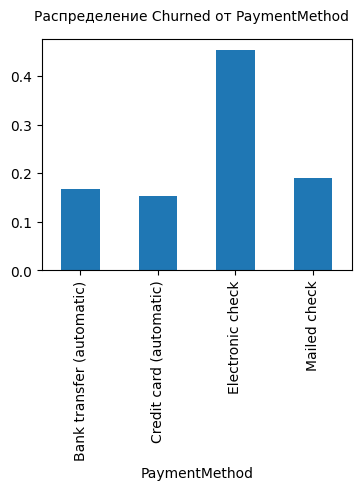

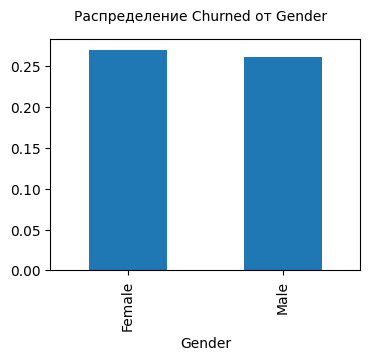

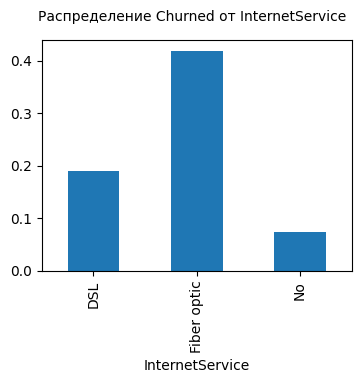

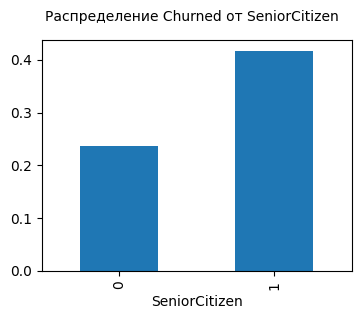

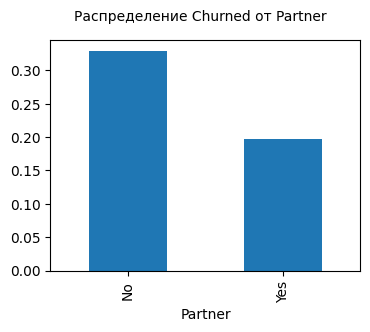

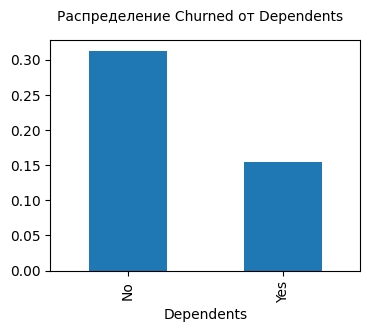

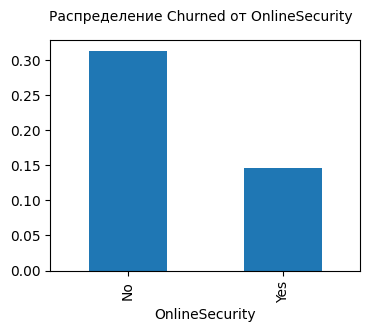

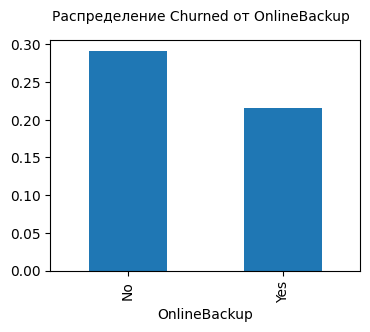

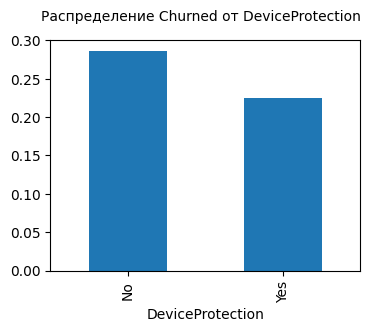

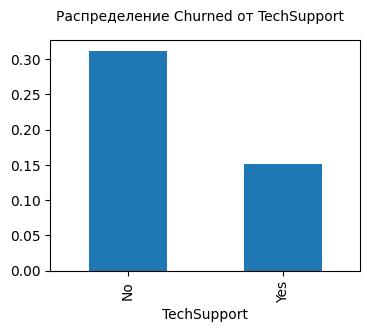

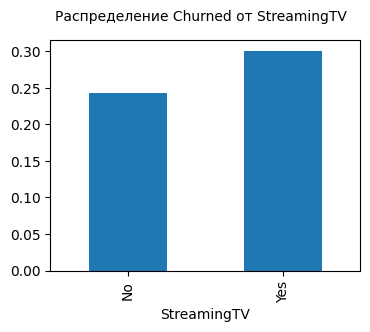

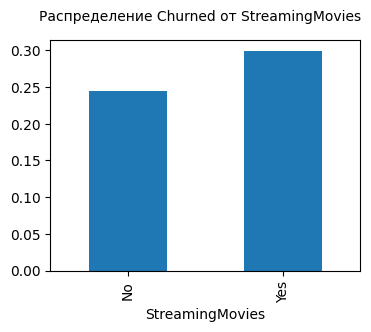

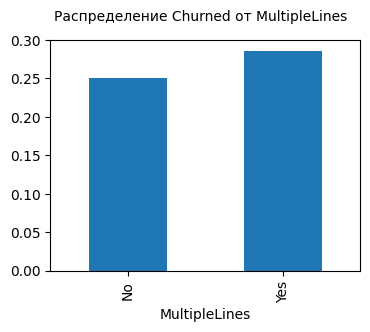

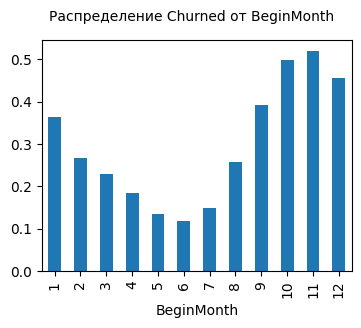

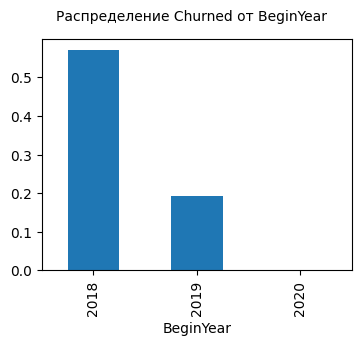

In [74]:
for c in (categorical_columns):
  fig = plt.figure(figsize=(4, 3))
  df_merged.groupby(c)[target].mean().plot(kind='bar');
  fig.suptitle(f'Распределение {target} от {c}', fontsize=10)
  plt.show()

In [75]:
len(df_merged.columns)

20

### Подготовка выборок

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    df_merged.drop(target, axis=1),
    df_merged[target],
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=df_merged[target]
)

In [77]:
X_train.shape

(5282, 19)

In [78]:
X_test.shape

(1761, 19)

In [79]:
y_train.mean()

0.2654297614539947

In [80]:
y_test.mean()

0.26519023282226006

### Выводы


*   На этапе предобработки данных исходные таблицы были объединены, а так же была выделена бинарная целевая переменная `Churned`
*   Корреляционный анализ признаков показал явные зависимости целевой переменной от некоторых числовых и категориальных признаков, например:
  *   Вероятность отмены контракта коррелирует с общими расходами по контракту
  *   Клиенты с оплатой от месяца к месяцу отменяют контракт реже, чем клиенты с фиксированным периодом контракта
  *   Клиенты, оплачивающие контракт электронным чеком, отменяют контракт реже
  *   Клиенты с подключением по оптоволокну отменяют реже остальных клиентов
  *   Клиенты с партнером и/или детьми отменяют контракт реже
  *   Такие услуги, как онлайн безопасность, бэкап данных, защита устройства и тех поддержка понижают вероятность отмены контракта

*  Данные были разбиты на обучающую и тестовую выборки в пропорции 75:25







## Обучение модели

In [81]:
processing_pipe = Pipeline([
    ('transform_columns', ColumnTransformer([
        ('numerical', Pipeline([
            ("scaler", StandardScaler()),
            ("imputer", SimpleImputer())
        ]), numeric_columns),
        ('categorical', OneHotEncoder(), categorical_columns),
    ]))
])

### Dummy модель

In [88]:
dummy_training_pipe = Pipeline([
    ("preprocessing", processing_pipe),
    ("training", DummyClassifier())
])

In [89]:
dummy_training_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('transform_columns',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler()),
                                                                                   ('imputer',
                                                                                    SimpleImputer())]),
                                                                   ['MonthlyCharges',
                                                                    'TotalCharges']),
                                                                  ('categorical',
                                                                   OneHotEncoder(),
                                                                   ['ContractType',
                                                                    'PaymentMethod',
                                                                    'Gender',
                                                                    'InternetService',
                                                                    'SeniorCitizen',
                                                                    'Partner',
                                                                    'Dependents',
                                                                    'OnlineSecurity',
                                                                    'OnlineBackup',
                                                                    'DeviceProtection',
                                                                    'TechSupport',
                                                                    'StreamingTV',
                                                                    'StreamingMovies',
                                                                    'MultipleLines',
                                                                    'BeginMonth',
                                                                    'BeginYear'])]))])),
                ('training', DummyClassifier())])

In [90]:
y_pred = dummy_training_pipe.predict(X_train)
roc_auc_score(y_train, y_pred)

0.5

### Случайный лес

In [91]:
rf_training_pipe = Pipeline([
    ("preprocessing", processing_pipe),
    ("training", RandomForestClassifier(random_state=RANDOM_STATE))
])

In [92]:
rf_params = {
    'training__n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'training__max_features': ['auto', 'sqrt']
}

In [93]:
rf_grid = RandomizedSearchCV(
    estimator = rf_training_pipe,
    param_distributions = rf_params,
    scoring='roc_auc',
    n_iter = 10,
    cv = 3,
    verbose=3,
    random_state=RANDOM_STATE,
    n_jobs = -1
)

In [94]:
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('transform_columns',
                                                               ColumnTransformer(transformers=[('numerical',
                                                                                                Pipeline(steps=[('scaler',
                                                                                                                 StandardScaler()),
                                                                                                                ('imputer',
                                                                                                                 SimpleImputer())]),
                                                                                                ['MonthlyCharges',
                                                                                                 'TotalCharges']),
                                                                                               ('categorical',
                                                                                                OneHotEncoder(),
                                                                                                ['ContractType',
                                                                                                 'PaymentMethod',
                                                                                                 'Gender',
                                                                                                 'InternetService',
                                                                                                 'S...
                                                                                                 'DeviceProtection',
                                                                                                 'TechSupport',
                                                                                                 'StreamingTV',
                                                                                                 'StreamingMovies',
                                                                                                 'MultipleLines',
                                                                                                 'BeginMonth',
                                                                                                 'BeginYear'])]))])),
                                             ('training',
                                              RandomForestClassifier(random_state=120624))]),
                   n_jobs=-1,
                   param_distributions={'training__max_features': ['auto',
                                                                   'sqrt'],
                                        'training__n_estimators': [200, 400,
                                                                   600, 800,
                                                                   1000, 1200,
                                                                   1400, 1600,
                                                                   1800,
                                                                   2000]},
                   random_state=120624, scoring='roc_auc', verbose=3)

In [95]:
rf_grid.best_params_

{'training__n_estimators': 2000, 'training__max_features': 'sqrt'}

In [96]:
rf_grid.best_score_

0.8692024646217874

### XGBoost

In [97]:
xgb_training_pipe = Pipeline([
    ("preprocessing", processing_pipe),
    ("training", XGBClassifier(random_state=RANDOM_STATE))
])

In [98]:
xgb_params = {
  'training__max_depth':range(3, 10, 1),
  'training__min_child_weight':range(1, 6, 1),
  'training__gamma':[i/10.0 for i in range(0,5)]
}

In [99]:
xgb_grid = RandomizedSearchCV(
    estimator = xgb_training_pipe,
    param_distributions = xgb_params,
    scoring='roc_auc',
    n_iter = 10,
    cv = 3,
    verbose=3,
    random_state=RANDOM_STATE,
    n_jobs = -1
)

In [100]:
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('transform_columns',
                                                               ColumnTransformer(transformers=[('numerical',
                                                                                                Pipeline(steps=[('scaler',
                                                                                                                 StandardScaler()),
                                                                                                                ('imputer',
                                                                                                                 SimpleImputer())]),
                                                                                                ['MonthlyCharges',
                                                                                                 'TotalCharges']),
                                                                                               ('categorical',
                                                                                                OneHotEncoder(),
                                                                                                ['ContractType',
                                                                                                 'PaymentMethod',
                                                                                                 'Gender',
                                                                                                 'InternetService',
                                                                                                 'S...
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=120624, ...))]),
                   n_jobs=-1,
                   param_distributions={'training__gamma': [0.0, 0.1, 0.2, 0.3,
                                                            0.4],
                                        'training__max_depth': range(3, 10),
                                        'training__min_child_weight': range(1, 6)},
                   random_state=120624, scoring='roc_auc', verbose=3)

In [101]:
xgb_grid.best_params_

{'training__min_child_weight': 5,
 'training__max_depth': 4,
 'training__gamma': 0.2}

In [102]:
xgb_grid.best_score_

0.8758429166101139

### Нейронная сеть

In [103]:
X_train_processed = processing_pipe.fit_transform(X_train)
X_train_processed.shape

(5282, 49)

In [104]:
X_nn_train, X_nn_valid, y_nn_train, y_nn_valid = train_test_split(
    X_train_processed,
    y_train,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y_train
)

In [105]:
torch.manual_seed(RANDOM_STATE)

input_size = X_nn_train.shape[1]
hidden_1_size = 16
hidden_2_size = 4
output_size = 1

num_epochs = 1000
batch_size = 100
learning_rate = 0.01

In [106]:
class NeuralNet(nn.Module):
    def __init__(self, hidden_1_size, hidden_2_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_1_size)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_1_size, hidden_2_size)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(hidden_2_size, output_size)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.output(x))
        return x

In [107]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.normal_(layer.weight)
        nn.init.normal_(layer.bias)

In [108]:
class Data(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray) -> None:
    self.X = torch.from_numpy(X.astype(np.float32))
    self.y = torch.from_numpy(y.astype(np.float32)).unsqueeze(1)
    self.len = self.X.shape[0]

  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]

  def __len__(self) -> int:
    return self.len

In [109]:
train_data = Data(X_nn_train, y_nn_train.to_numpy())

In [110]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

In [111]:
model = NeuralNet(hidden_1_size, hidden_2_size)
model.apply(init_weights)
print(model)

NeuralNet(
  (layer1): Linear(in_features=49, out_features=16, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=16, out_features=4, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
  (act3): Sigmoid()
)


In [112]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [113]:
history = []
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        running_loss += loss.item()

    if (epoch == 0 or (epoch + 1) % 100 == 0):
        print(f'Epochs:{epoch + 1:5d} | Loss: {running_loss / (i + 1):.10f}')

    history.append(running_loss / (i + 1))

Epochs:    1 | Loss: 0.9687813252
Epochs:  100 | Loss: 0.2880288638
Epochs:  200 | Loss: 0.2648497272
Epochs:  300 | Loss: 0.2552214991
Epochs:  400 | Loss: 0.2424778098
Epochs:  500 | Loss: 0.2381149463
Epochs:  600 | Loss: 0.2341638640
Epochs:  700 | Loss: 0.2374571554
Epochs:  800 | Loss: 0.2317111690
Epochs:  900 | Loss: 0.2338795483
Epochs: 1000 | Loss: 0.2242277248


In [114]:
y_train_pred = model(torch.from_numpy(X_nn_train.astype(np.float32))).detach().numpy()

In [115]:
roc_auc_score(y_nn_train, y_train_pred)

0.9617901131633757

In [116]:
y_valid_pred = model(torch.from_numpy(X_nn_valid.astype(np.float32))).detach().numpy()

In [117]:
roc_auc_score(y_nn_valid, y_valid_pred)

0.819992950920786

### Выводы

На этапе обучения модели была натренированна dummy модель, а так же 3 "реальных" модели с измеренем показателя ROC AUC в качестве метрики качества:
- Случайный лес: ROC AUC 0.869 при кросс валидации
- XGBoost: ROC AUC 0.876 при кросс валадации
- Полносвязная нейронная сеть: 0.820 на валидационной выборке

Таким образом на этапе обучения наилучшую точность показала модель XGBoost, поэтому в дальнейшем рекомендуем использовать ее для решения поставленной задачи.

## Тестирование модели

Проведем тестирование обученной модели XGBoost

### ROC AUC

In [123]:
xgb_grid.score(X_test, y_test)

0.8715162055806903

### Accuracy

In [126]:
predictions = xgb_grid.predict(X_test)

In [127]:
accuracy_score(y_test, predictions)

0.8245315161839863

### Матрица ошибок

In [171]:
cm = confusion_matrix(y_test, predictions)
cm

array([[1162,  132],
       [ 177,  290]])

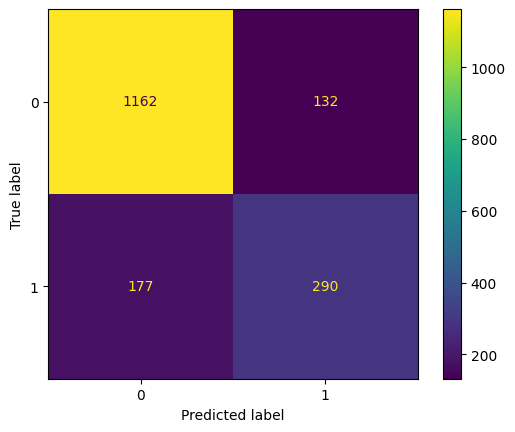

In [134]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

### Точность

In [172]:
tn, fp, fn, tp = cm.ravel()

In [173]:
tp / (tp + fp)

0.6872037914691943

### Полнота

In [174]:
tp / (tp + fn)

0.6209850107066381

### Важность признаков

In [151]:
X_test_preprocessed = processing_pipe.transform(X_test)
explainer = shap.Explainer(xgb_grid.best_estimator_.named_steps['training'], feature_names = processing_pipe.get_feature_names_out())
shap_values = explainer(X_test_preprocessed)

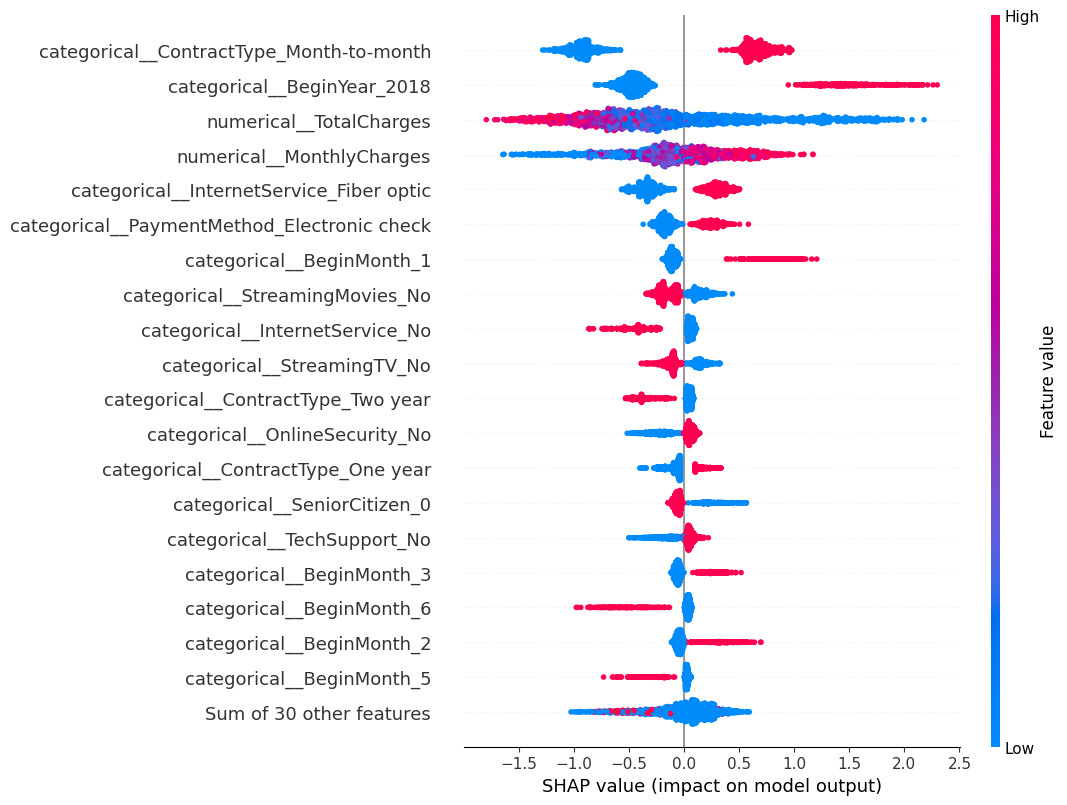

In [153]:
shap.plots.beeswarm(shap_values, max_display=20)

Признаки, наибольшим образом влияющие на предсказания модели:
- Тип контракта
  - Признак, говорящий о том, что клиент оплачивает контракт помесячно, наибольшим образом влияет на предсказание модели и увеличивает вероятность отмены контракта
- Год подписания контракта
  -  Клиенты, подписавшие контракт в 2018 году, расторгают контракт с большей вероятностью
- Общая сумма платежей
  -  Чем больше общая сумма платежей, тем меньше вероятность отмены контракта


Посмотрим внимательнее на корреляционную зависимость типа оплаты контракта и вероятности отмены контракта, чтобы убедиться, что результаты оценки важности признаков соответствуют зависимостям в исходных данных

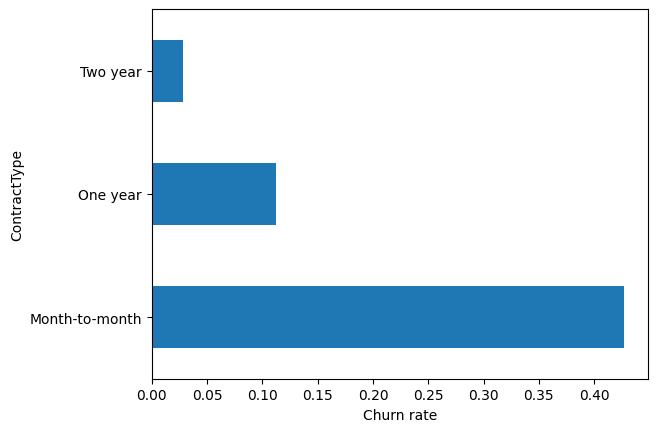

In [160]:
df_merged.groupby('ContractType')['Churned'].mean().plot(kind='barh', xlabel='Churn rate');

Как видно из графика выше, действительно клиенты с помесячным типом оплаты контракта в среднем отменяют контракт с большей вероятность (>40% таких клиентов отменили контракт), чем клиенты с годичными или двухгодичными контрактами. Из этого можно сделать вывод, что для бизнеса гораздо выгоднее иметь клиентов с долгосрочными контактами, так как они с меньшей вероятностью отменят его.

## Вывод

**Итоги работы**

Целью проекта было создание модели для предсказания оттока клиентов оператора связи «ТелеДом». Проект включал следующие этапы:

- Были загружены и объединены таблицы с данными о контрактах, персональными данными клиентов, информацией об интернет-услугах и телефонии.

- Выявлены пропуски в столбцах EndDate и TotalCharges таблицы контрактов, которые были обработаны соответствующим образом. Проведен анализ на наличие аномалий, дубликатов и выбросов, результаты которого показали отсутствие значительных проблем в данных.

- Таблицы были объединены, а целевая переменная (Churned) была выделена.
Проведен корреляционный анализ признаков, выявивший несколько ключевых зависимостей между признаками и целевой переменной.

- Были обучены и протестированы следующие модели: Dummy-модель, случайный лес, XGBoost и полносвязная нейронная сеть.
Модель XGBoost показала наилучшие результаты с ROC AUC 0.876 при кросс-валидации.


- На тестовой выборке модель XGBoost продемонстрировала следующие метрики:
  - ROC AUC: 0.8715
  - Accuracy: 0.8245
  - Точность: 0.6872
  - Полнота: 0.6209

Таким образом, была достигнута желаемая точность выше 0.85 по метрике ROC AUC на тестовой выборке.

- Наибольшее влияние на предсказания модели оказали следующие признаки:
  - Тип контракта: Клиенты с помесячной оплатой чаще расторгают контракты.
  - Год подписания контракта: Контракты, подписанные в 2018 году, чаще расторгаются.
  - Общая сумма платежей: Чем больше сумма платежей, тем меньше вероятность расторжения контракта.


**Способы для дальнейшего улучшения модели**


- Улучшение качества данных: обработка пропусков и аномалий, добавление новых признаков (например, данные о взаимодействии с клиентской поддержкой, оценки удовлетворенности клиентов).

- Оптимизация гиперпараметров: проведение более детальной оптимизации гиперпараметров модели XGBoost с использованием методов, таких как Grid Search или Bayesian Optimization


- Регулярное обновление модели: переобучение модели на новых данных для адаптации к изменяющимся условиям.


**Бизнес-рекомендации заказчику**


- Фокус на долгосрочные контракты: разработать и активно продвигать предложения с выгодными условиями для долгосрочных контрактов.

- Поощрение использования дополнительных услуг: активное информирование клиентов о преимуществах дополнительных услуг (онлайн безопасность, бэкап данных, защита устройства и техподдержка) и их предложение в пакетах с основными тарифами.


- Персонализированные предложения: использование предсказательной модели для выявления клиентов с высоким риском оттока и предложение им индивидуальных скидок или специальных условий

- Регулярный мониторинг показателей оттока и анализ эффективности внедренных мер для оперативного реагирования на изменения и адаптации стратегий удержания клиентов.


Внедрение данных рекомендаций поможет не только снизить отток клиентов, но и повысить общую лояльность к оператору связи «ТелеДом», что в долгосрочной перспективе приведет к росту прибыли компании.